In [1]:
from masters.env_wrapper import make_wrapped_env
from masters.networks.actor import Actor
from masters.networks.critic import Critic
from masters.a2c.trainer import A2CTrainer
from masters.a2c.agent import A2CAgent
from bindsnet.encoding.encoders import GaussianReceptiveFieldsEncoder
from IPython.display import Image
import torch
from matplotlib import pyplot as plt
import logging

logging.basicConfig(level="INFO")

In [2]:
cartpole_info = {
    0: dict(start=-4.8, end=4.8, scale=0.5, n=20),
    1: dict(start=-10, end=10, scale=0.1, n=100),
    2: dict(start=-0.418, end=0.418, scale=0.02, n=40),
    3: dict(start=-10, end=10, scale=0.2, n=100),
}

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
encoder = GaussianReceptiveFieldsEncoder(encoding_info=cartpole_info, intensity=200)

In [5]:
actor = Actor(
    input_shape=[260],
    output_shape=[50, 2],
    a_minus=-1e-2,
    a_plus=5e-2,
    thresh=-58.,
#     norm=0.7,
    time=100,
    dev=True
)
critic = Critic(
    input_shape=[260],
    output_shape=[100],
    a_minus=-1e-2,
    a_plus=5e-2,
    thresh=-57.,
#     norm=0.7,
    time=100,
    dev=True
)

In [6]:
agent = A2CAgent(
    actor=actor,
    critic=critic,
    encoder=encoder,
)

INFO:masters.a2c.agent:Actor:
         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'In' (trainable)
   260 neurons [260]
       ·connected to 'Out' by 26,000 synapses
    ··········································
    Layer: 'Out' (trainable)
   100 neurons [50, 2]
Total neurons: 360 (360 trainable)
Total synapses weights: 26,000 (26,000 trainable)
INFO:masters.a2c.agent:Critic:
         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'In' (trainable)
   260 neurons [260]
       ·connected to 'Out' by 26,000 synapses
    ··········································
    Layer: 'Out' (trainable)
   100 neurons [100]
Total neurons: 360 (360 trainable)
Total synapses weights: 26,000 (26,000 trainable)


In [7]:
agent.to(device)

In [8]:
trainer = A2CTrainer(
    num_episodes=100,
    max_steps=10000,
    gamma=0.95,
    spikes_to_value=1,
    start_actor_train=0,
    log=True,
    experiment_name="experiments"
)#, device=device)

INFO:masters.a2c.trainer:Initialized TensorBoard log_dir:
/home/dan/Projects/masters/data/logs/experiments/5e272928-f4e7-11eb-b83c-e8f408dbdf30


In [9]:
trainer.fit(agent, "CartPole-v0", num_episodes=500)

INFO:masters.a2c.trainer:Total reward after 0 episodes: 48.0
INFO:masters.a2c.trainer:Total reward after 1 episodes: 12.0
INFO:masters.a2c.trainer:Total reward after 2 episodes: 48.0
INFO:masters.a2c.trainer:Total reward after 3 episodes: 10.0


KeyboardInterrupt: 

In [19]:
%debug

> /home/dan/Projects/masters/bindsnet/bindsnet/learning/learning.py(587)_connection_update()
    585         self.p_plus += a_plus * source_s
    586         self.p_minus *= torch.exp(-self.connection.dt / self.tc_minus)
--> 587         self.p_minus += a_minus * target_s
    588 
    589         # Calculate point eligibility value.

ipdb> a_minus.shape
torch.Size([])
ipdb> target_s.shape
torch.Size([1, 100])
ipdb> u
> /home/dan/Projects/masters/bindsnet/bindsnet/network/topology.py(102)update()
    100 
    101         if learning:
--> 102             self.update_rule.update(**kwargs)
    103 
    104         mask = kwargs.get("mask", None)

ipdb> **kwargs
*** SyntaxError: invalid syntax
ipdb> kwargs
{'mask': None, 'learning': True, 'reward': 0.8965004682540894, 'unclamp': {'Out': tensor([[[False,  True],
         [False,  True],
         [False,  True],
         ...,
         [False,  True],
         [False,  True],
         [False,  True]],

        [[False,  True],
         [False, 

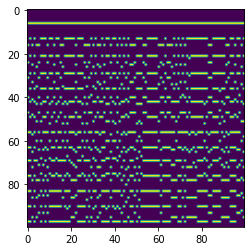

In [18]:
plt.imshow(agent.critic.monitors["Out"].get("s").squeeze(1))

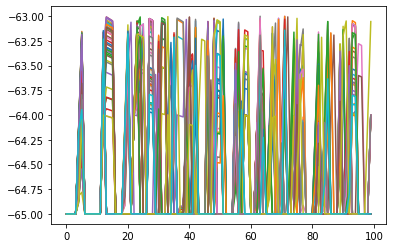

In [19]:
plt.plot(agent.critic.monitors["Out"].get("v").squeeze(1))

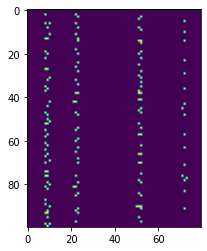

In [28]:
plt.imshow(agent.critic.monitors["In"].get("s").squeeze(1))

In [22]:
episode = trainer.play_episode(agent, "CartPole-v0", render=True)

(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

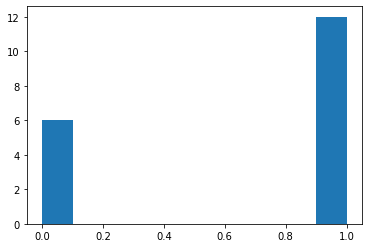

In [23]:
plt.hist([t.action for t in episode.transitions], bins=10)

In [11]:
transition = episode.transitions[-1]

In [12]:
agent.run_actor(
    observation=torch.from_numpy(transition.observation),
)

1

In [13]:
trainer.compute_delta(
    agent,
    observation=torch.from_numpy(transition.observation),
    prev_observation=torch.from_numpy(transition.prev_observation),
    reward=transition.reward,
    done=transition.done
)

-2.5999999046325684

In [32]:
agent.run_critic(torch.from_numpy(transition.observation))

4.880000114440918

In [33]:
agent.run_critic(torch.from_numpy(transition.prev_observation))

5.0

In [37]:
spikes = agent.run_net(torch.from_numpy(transition.observation), agent.critic, max_time=100, output_layer=agent.output_critic_layer)

In [41]:
spikes.float().mean(dim=-1).sum()

tensor(3.4200)

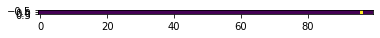

In [54]:
plt.imshow(agent.critique.monitors["Out"].get("s").view(100, -1).t())

In [ ]:
agent.actor.monitors["Out"].get("s").squeeze(1).sum()

In [ ]:
agent.actor.connections[("In", "l1")].w.numpy().mean()

In [ ]:
agent.actor.layers["Out"].shape

In [ ]:
clamp = torch.BoolTensor([0, 1])

In [ ]:
clamp[..., 0] = 1

In [ ]:
clamp